This script takes the GO terms predicted by the 4 methods (which have been joined into a single file), and the COG terms predicted by eggnog-mapper. Then it trains a model that is able to predict the COG terms based on the GO terms. Models to use: Random Forest, XGBoost, LightGBM, CatBoost. The best model is then used to predict the COG terms for the test set.


In [2]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os



### 2. Loading data

In [3]:
# Load GO terms
go_terms_df = pd.read_csv("../tables/all_tidy_FINAL.csv")

# Load COG categories
cog_categories_df = pd.read_csv("../tables/eggnog_COG_categories.csv")

# remove entries in cog_categories_df where COG_category is S
cog_categories_df = cog_categories_df[cog_categories_df.COG_category != "S"]

### 3. Data preprocessing

One-Hot Encoding of GO Terms:
- Since GO terms are categorical, we need to convert them into a numerical representation that machine learning models can understand. One-hot encoding is a suitable method for this.
- Each unique GO term will become a new binary feature (column).
- If a gene has a particular GO term, the value in the corresponding column will be 1, otherwise 0.
- We will create a matrix where rows represent genes and columns represent GO terms.

In [5]:
# Create a unique set of genes from both dataframes
all_genes = set(go_terms_df['gene_family']).union(set(cog_categories_df['original_id']))

# Create an empty dataframe for one-hot encoding, with a column for each unique GO term
go_terms_encoded = pd.DataFrame(index=list(all_genes), columns=go_terms_df['GO'].unique())
go_terms_encoded = go_terms_encoded.fillna(0)  # Fill with 0s initially

# Fill the one-hot encoded dataframe
for index, row in go_terms_df.iterrows():
    go_terms_encoded.at[row['gene_family'], row['GO']] = 1

/var/folders/xy/wf6xxhnx3hx557yklnkjk7zr0000gn/T/ipykernel_17047/173127624.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  go_terms_encoded = go_terms_encoded.fillna(0)  # Fill with 0s initially


In [7]:
go_terms_encoded.head()

,GO:0000041,GO:0003674,GO:0005215,GO:0005381,GO:0005575,GO:0005623,GO:0006810,GO:0006811,GO:0006812,GO:0006826,...,GO:0031306,GO:0007605,GO:0033689,GO:0002076,GO:0070593,GO:0005178,GO:1990026,GO:1905240,GO:2001223,GO:0097442
pspC,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_30239,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_37917,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rbsD,0,1,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
group_5795,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Preparing COG Category Labels:

- We need to create a similar structure for COG categories, where each row corresponds to a gene, and each column represents a COG category.

- Since a gene can have multiple COG categories, this will be a multi-label representation (also binary: 1 if the gene has the category, 0 otherwise).

In [8]:
# Get unique COG categories
cog_categories = cog_categories_df['COG_category'].unique()

# Create an empty dataframe for COG categories
cog_labels = pd.DataFrame(index=list(all_genes), columns=cog_categories)
cog_labels = cog_labels.fillna(0)  # Initialize with 0s

# Fill the COG labels dataframe
for index, row in cog_categories_df.iterrows():
    cog_labels.at[row['original_id'], row['COG_category']] = 1

/var/folders/xy/wf6xxhnx3hx557yklnkjk7zr0000gn/T/ipykernel_17047/1452552284.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cog_labels = cog_labels.fillna(0)  # Initialize with 0s


Removing Genes Without COG categories:

- Now, we must remove those genes for which we have no COG categories.

- We will also do the same for the encoded GO terms.

In [9]:
# Remove genes without COG categories
cog_labels = cog_labels.loc[cog_labels.sum(axis=1) > 0]

# Remove genes without GO terms
go_terms_encoded = go_terms_encoded.loc[cog_labels.index]

### 4. Train/Test Split

Before we proceed further, it's crucial to split our data into training and testing sets. This will allow us to evaluate the performance of our models on unseen data. We'll use train_test_split from sklearn.model_selection.

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    go_terms_encoded, cog_labels, test_size=0.2, random_state=42
)

Evaluation Metrics for Multiclass, Multi-label Classification:

Since you have a multiclass, multi-label problem, we need to use appropriate evaluation metrics:

1. Hamming Loss: Measures the fraction of labels that are incorrectly predicted. Lower is better.

2. Exact Match Ratio: Measures the fraction of samples where all labels are predicted correctly. Higher is better.

3. Accuracy: Measures the overall accuracy across all labels.

4. Precision: Measures the ability of the classifier not to label as positive a sample that is negative, for each label.

5. Recall: Measures the ability of the classifier to find all the positive samples for each label.

6. F1-score: The harmonic mean of precision and recall for each label.

7. AUC-ROC: While typically used for binary classification, it can be extended to multi-label scenarios by considering each label independently (one-vs-all approach).

## Feature Selection Methods

### Variance Threshold:

Concept: This is a simple baseline approach that removes features with low variance across samples. The rationale is that features that don't vary much are unlikely to be informative for prediction.

Implementation: We can use the VarianceThreshold class from sklearn.feature_selection.

In [22]:
from sklearn.feature_selection import VarianceThreshold

# Example: Remove features with variance below a certain threshold (e.g., 0.01)
selector = VarianceThreshold(threshold=0.005)  # Adjust threshold as needed
X_train_vt = selector.fit_transform(X_train)
X_test_vt = selector.transform(X_test)

# Get the indices of the selected features
selected_features_vt = X_train.columns[selector.get_support()]

# Update the training and testing sets to keep only the selected features
X_train_vt = X_train[selected_features_vt]
X_test_vt = X_test[selected_features_vt]

# Print the number of features before and after feature selection
print(f"Number of features before feature selection: {X_train.shape[1]}")
print(f"Number of features after feature selection: {X_train_vt.shape[1]}")

Number of features before feature selection: 9706
Number of features after feature selection: 641


### Chi-Squared Test:

Concept: The chi-squared test measures the dependence between a feature and the target variable. Features that are independent of the target are less likely to be relevant. This is suitable for categorical features like our one-hot encoded GO terms.

Implementation: We can use SelectKBest or SelectPercentile in combination with chi2 from sklearn.feature_selection.

In [45]:
from sklearn.feature_selection import SelectKBest, chi2

# Example: Select top 500 features based on chi-squared statistic
selector = SelectKBest(chi2, k=1000)  # Adjust k (number of features) as needed
X_train_chi2 = selector.fit_transform(X_train, y_train)
X_test_chi2 = selector.transform(X_test)

# Get the indices of the selected features
selected_features_chi2 = X_train.columns[selector.get_support()]

# Update the training and testing sets
X_train_chi2 = X_train[selected_features_chi2]
X_test_chi2 = X_test[selected_features_chi2]

# Print the number of features before and after feature selection
print(f"Number of features before feature selection: {X_train.shape[1]}")
print(f"Number of features after feature selection: {X_train_chi2.shape[1]}")


Number of features before feature selection: 9706
Number of features after feature selection: 1000


## 2. Model Training with Cross-Validation

In [34]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier

# Define the models wrapped in MultiOutputClassifier
rf_model = MultiOutputClassifier(RandomForestClassifier(random_state=42), n_jobs=-1)
xgb_model = MultiOutputClassifier(XGBClassifier(random_state=42, objective='binary:logistic'), n_jobs=-1)

# We'll use RepeatedStratifiedKFold for a more robust estimation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Metrics to evaluate (add more if needed)
scoring = ['accuracy', 'f1_micro', 'f1_macro']  # Example metrics

# Perform cross-validation for Random Forest
print("Cross-validating Random Forest...")
cv_results_rf = cross_validate(
    rf_model,
    X_train_vt,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1  # Use all available cores for faster processing
)
print("Cross-validating Random Forest... Done")

# Perform cross-validation for XGBoost
print("Cross-validating XGBoost...")
cv_results_xgb = cross_validate(
    xgb_model,
    X_train_vt,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)
print("Cross-validating XGBoost... Done")

# Store the results in DataFrames for easier analysis
cv_results_rf_df = pd.DataFrame(cv_results_rf)
cv_results_xgb_df = pd.DataFrame(cv_results_xgb)

# Print or analyze the results
print("Random Forest CV Results:\n", cv_results_rf_df)
print("\nXGBoost CV Results:\n", cv_results_xgb_df)

Cross-validating Random Forest...


/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Cross-validating Random Forest... Done
Cross-validating XGBoost...


/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Cross-validating XGBoost... Done
Random Forest CV Results:
     fit_time  score_time  test_accuracy  train_accuracy  test_f1_micro  \
0  82.707763    2.260447       0.570259        0.929617       0.693446   
1  82.900044    2.124308       0.573193        0.930350       0.695551   
2  83.052930    2.402466       0.564324        0.928847       0.690569   
3  82.864061    2.394511       0.580849        0.928577       0.710085   
4  83.525962    2.372045       0.571429        0.926299       0.699549   

   train_f1_micro  test_f1_macro  train_f1_macro  
0        0.959327       0.579879        0.964078  
1        0.960249       0.573963        0.965851  
2        0.959228       0.566331        0.963849  
3        0.959133       0.611244        0.962582  
4        0.957872       0.591658        0.958376  

XGBoost CV Results:
     fit_time  score_time  test_accuracy  train_accuracy  test_f1_micro  \
0  45.852144    3.294926       0.507258        0.597390       0.656473   
1  45.465677    3.5

### 3. Fine tunning the model

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold

# Define the models
rf_model = MultiOutputClassifier(RandomForestClassifier(random_state=42), n_jobs=-1)
xgb_model = MultiOutputClassifier(XGBClassifier(random_state=42, objective='binary:logistic'), n_jobs=-1)

# Define hyperparameter search spaces
rf_param_dist = {
    'estimator__n_estimators': randint(50, 200),
    'estimator__max_depth': randint(5, 20),
    'estimator__min_samples_split': randint(2, 10),
    'estimator__min_samples_leaf': randint(1, 5),
    'estimator__max_features': ['sqrt', 'log2']
}

xgb_param_dist = {
    'estimator__n_estimators': randint(50, 200),
    'estimator__learning_rate': uniform(0.01, 0.2),
    'estimator__max_depth': randint(3, 10),
    'estimator__subsample': uniform(0.6, 0.4),
    'estimator__colsample_bytree': uniform(0.6, 0.4)
}

# KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Use RandomizedSearchCV for Random Forest
print("Tuning Random Forest with RandomizedSearchCV...")
random_search_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1_micro',
    n_jobs=-1,
    random_state=42
)
random_search_rf.fit(X_train_vt, y_train)
print("Tuning Random Forest... Done")

# Use RandomizedSearchCV for XGBoost
print("Tuning XGBoost with RandomizedSearchCV...")
random_search_xgb = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1_micro',
    n_jobs=-1,
    random_state=42
)
random_search_xgb.fit(X_train_vt, y_train)
print("Tuning XGBoost... Done")

# Print the best hyperparameters and scores
print("Best Random Forest Hyperparameters:", random_search_rf.best_params_)
print("Best Random Forest Score:", random_search_rf.best_score_)
print("\nBest XGBoost Hyperparameters:", random_search_xgb.best_params_)
print("Best XGBoost Score:", random_search_xgb.best_score_)

Tuning Random Forest with RandomizedSearchCV...


/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuning Random Forest... Done
Tuning XGBoost with RandomizedSearchCV...
Tuning XGBoost... Done
Best Random Forest Hyperparameters: {'estimator__max_depth': 19, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 99}
Best Random Forest Score: 0.5743498459485173

Best XGBoost Hyperparameters: {'estimator__colsample_bytree': 0.9757995766256756, 'estimator__learning_rate': 0.18896547008552977, 'estimator__max_depth': 8, 'estimator__n_estimators': 144, 'estimator__subsample': 0.9687496940092467}
Best XGBoost Score: 0.6778815889681847


### 4. Model Evaluation

In [36]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    hamming_loss,
    jaccard_score,
)

# Train the best Random Forest model on the full training data
best_rf_model = MultiOutputClassifier(
    RandomForestClassifier(
        max_depth=19,
        max_features='sqrt',
        min_samples_leaf=2,
        min_samples_split=2,
        n_estimators=99,
        random_state=42
    ),
    n_jobs=-1
)
best_rf_model.fit(X_train_vt, y_train)

# Train the best XGBoost model on the full training data
best_xgb_model = MultiOutputClassifier(
    XGBClassifier(
        colsample_bytree=0.9758,
        learning_rate=0.1890,
        max_depth=8,
        n_estimators=144,
        subsample=0.9687,
        random_state=42,
        objective='binary:logistic'
    ),
    n_jobs=-1
)
best_xgb_model.fit(X_train_vt, y_train)

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test_vt)
y_pred_xgb = best_xgb_model.predict(X_test_vt)

# Evaluate the models on the test set
print("Random Forest Test Set Performance:")
print(classification_report(y_test, y_pred_rf))
print("Hamming Loss:", hamming_loss(y_test, y_pred_rf))
print("Exact Match Ratio (Subset Accuracy):", accuracy_score(y_test, y_pred_rf))
print("Jaccard Score (Micro):", jaccard_score(y_test, y_pred_rf, average='micro'))

print("\nXGBoost Test Set Performance:")
print(classification_report(y_test, y_pred_xgb))
print("Hamming Loss:", hamming_loss(y_test, y_pred_xgb))
print("Exact Match Ratio (Subset Accuracy):", accuracy_score(y_test, y_pred_xgb))
print("Jaccard Score (Micro):", jaccard_score(y_test, y_pred_xgb, average='micro'))

/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest Test Set Performance:
              precision    recall  f1-score   support

           0       0.90      0.53      0.67      2055
           1       0.95      0.56      0.71       432
           2       0.94      0.44      0.60       750
           3       0.96      0.65      0.78       220
           4       0.92      0.33      0.48       552
           5       0.89      0.41      0.56       982
           6       0.91      0.53      0.67       995
           7       0.90      0.51      0.65       444
           8       0.99      0.29      0.45       297
           9       0.96      0.18      0.31       279
          10       0.92      0.34      0.50       415
          11       0.98      0.44      0.60       215
          12       0.86      0.11      0.19       111
          13       0.00      0.00      0.00        26
          14       0.94      0.52      0.67       353
          15       0.92      0.37      0.53       197
          16       1.00      0.27      0.43  

/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [37]:
print("\nXGBoost Test Set Performance:")
print(classification_report(y_test, y_pred_xgb))
print("Hamming Loss:", hamming_loss(y_test, y_pred_xgb))
print("Exact Match Ratio (Subset Accuracy):", accuracy_score(y_test, y_pred_xgb))
print("Jaccard Score (Micro):", jaccard_score(y_test, y_pred_xgb, average='micro'))


XGBoost Test Set Performance:
              precision    recall  f1-score   support

           0       0.87      0.62      0.73      2055
           1       0.92      0.67      0.78       432
           2       0.92      0.56      0.70       750
           3       0.97      0.73      0.83       220
           4       0.85      0.54      0.66       552
           5       0.87      0.55      0.67       982
           6       0.89      0.63      0.74       995
           7       0.84      0.64      0.73       444
           8       0.96      0.42      0.59       297
           9       0.82      0.33      0.47       279
          10       0.85      0.49      0.62       415
          11       0.92      0.56      0.70       215
          12       0.84      0.32      0.47       111
          13       0.69      0.35      0.46        26
          14       0.91      0.63      0.74       353
          15       0.87      0.49      0.63       197
          16       0.95      0.46      0.62       

/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
print("Random Forest Test Set Performance:")
print(classification_report(y_test, y_pred_rf))
print("Hamming Loss:", hamming_loss(y_test, y_pred_rf))
print("Exact Match Ratio (Subset Accuracy):", accuracy_score(y_test, y_pred_rf))
print("Jaccard Score (Micro):", jaccard_score(y_test, y_pred_rf, average='micro'))

Random Forest Test Set Performance:
              precision    recall  f1-score   support

           0       0.90      0.53      0.67      2055
           1       0.95      0.56      0.71       432
           2       0.94      0.44      0.60       750
           3       0.96      0.65      0.78       220
           4       0.92      0.33      0.48       552
           5       0.89      0.41      0.56       982
           6       0.91      0.53      0.67       995
           7       0.90      0.51      0.65       444
           8       0.99      0.29      0.45       297
           9       0.96      0.18      0.31       279
          10       0.92      0.34      0.50       415
          11       0.98      0.44      0.60       215
          12       0.86      0.11      0.19       111
          13       0.00      0.00      0.00        26
          14       0.94      0.52      0.67       353
          15       0.92      0.37      0.53       197
          16       1.00      0.27      0.43  

/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


        feature  importance
351  GO:0006259    0.107868
3    GO:0005623    0.049270
51   GO:0044281    0.029528
598  GO:0006313    0.019466
591  GO:0015074    0.015001
..          ...         ...
476  GO:0071496    0.000000
134  GO:0015267    0.000000
325  GO:1901361    0.000000
127  GO:0046777    0.000000
455  GO:0009260    0.000000

[641 rows x 2 columns]


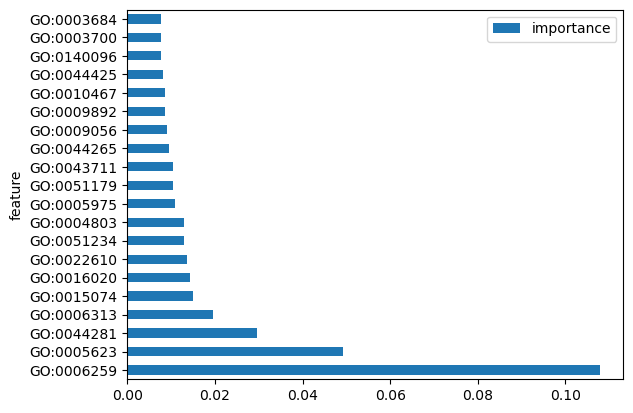

In [40]:
# Get feature importances from the best XGBoost model
importances = best_xgb_model.estimators_[0].feature_importances_

# Create a DataFrame for easier visualization
feature_importances = pd.DataFrame({'feature': X_train_vt.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Print or plot the feature importances
print(feature_importances)

# You can also plot the top N features:
import matplotlib.pyplot as plt
feature_importances.head(20).plot(x='feature', y='importance', kind='barh')
plt.show()

/var/folders/xy/wf6xxhnx3hx557yklnkjk7zr0000gn/T/ipykernel_17047/1392528249.py:13: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*(precision*recall)/(precision+recall)


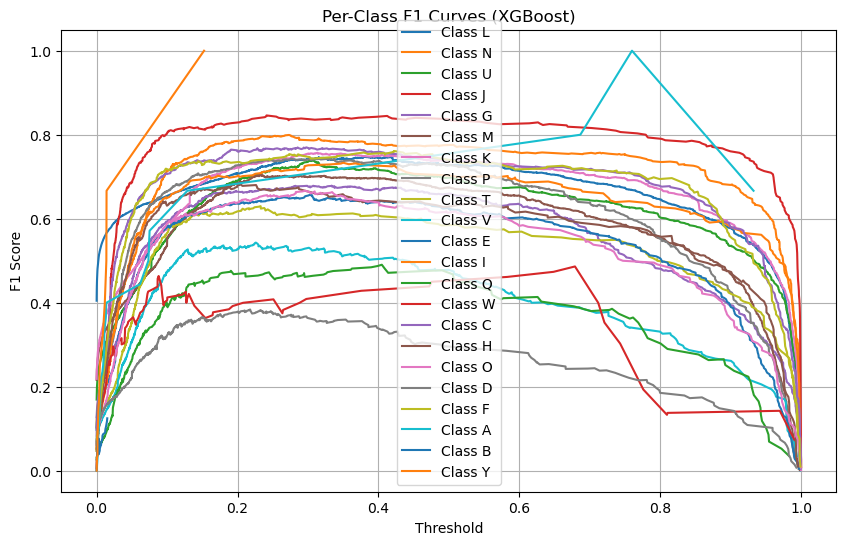

In [41]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Assuming you have already trained your best XGBoost model: best_xgb_model

# Get the predicted probabilities for each class on the test set
y_prob_xgb = best_xgb_model.predict_proba(X_test_vt)

# 1. Per-Class F1 Curves
plt.figure(figsize=(10, 6))
for i in range(y_test.shape[1]):  # Iterate over each COG category (label)
    precision, recall, thresholds = precision_recall_curve(y_test.iloc[:, i], y_prob_xgb[i][:, 1])  # Use probabilities for the positive class
    f1_scores = 2*(precision*recall)/(precision+recall)
    plt.plot(thresholds, f1_scores[:-1], label=f'Class {y_test.columns[i]}')

plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Per-Class F1 Curves (XGBoost)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


/var/folders/xy/wf6xxhnx3hx557yklnkjk7zr0000gn/T/ipykernel_17047/212807590.py:7: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*(precision*recall)/(precision+recall)


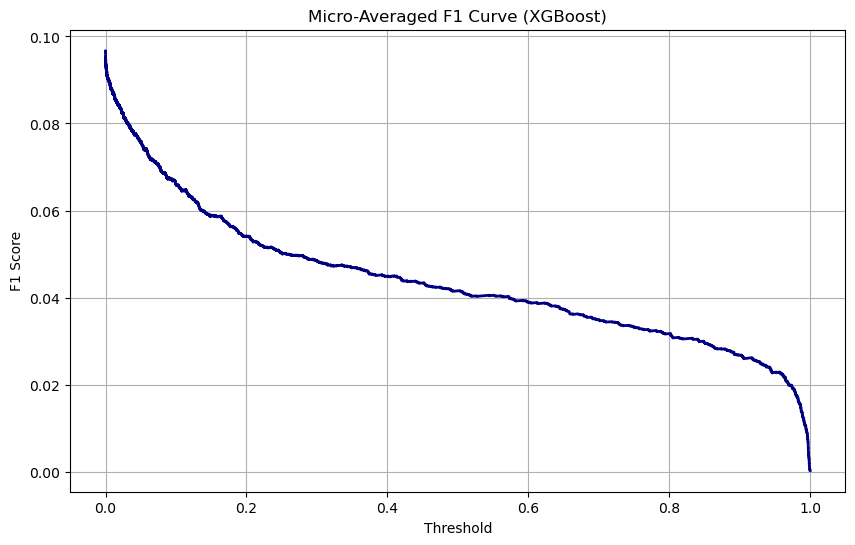

In [44]:
# 2. Micro-Averaged F1 Curve
# Flatten the true labels and predicted probabilities for micro-averaging
y_test_flat = y_test.values.ravel()
y_prob_flat = np.concatenate([y_prob_xgb[i][:, 1] for i in range(len(y_prob_xgb))]) # Assuming positive class probabilities are in the second column

precision, recall, thresholds = precision_recall_curve(y_test_flat, y_prob_flat)
f1_scores = 2*(precision*recall)/(precision+recall)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], color='navy', lw=2)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Micro-Averaged F1 Curve (XGBoost)')
plt.grid(True)
plt.show()

## 2. Model training from Chi-Squared features

In [46]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier

# Define the models wrapped in MultiOutputClassifier
rf_model = MultiOutputClassifier(RandomForestClassifier(random_state=42), n_jobs=-1)
xgb_model = MultiOutputClassifier(XGBClassifier(random_state=42, objective='binary:logistic'), n_jobs=-1)

# We'll use RepeatedStratifiedKFold for a more robust estimation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Metrics to evaluate (add more if needed)
scoring = ['accuracy', 'f1_micro', 'f1_macro']  # Example metrics

# Perform cross-validation for Random Forest
print("Cross-validating Random Forest...")
cv_results_rf = cross_validate(
    rf_model,
    X_train_chi2,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1  # Use all available cores for faster processing
)
print("Cross-validating Random Forest... Done")

# Perform cross-validation for XGBoost
print("Cross-validating XGBoost...")
cv_results_xgb = cross_validate(
    xgb_model,
    X_train_chi2,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)
print("Cross-validating XGBoost... Done")

# Store the results in DataFrames for easier analysis
cv_results_rf_df = pd.DataFrame(cv_results_rf)
cv_results_xgb_df = pd.DataFrame(cv_results_xgb)

# Print or analyze the results
print("Random Forest CV Results:\n", cv_results_rf_df)
print("\nXGBoost CV Results:\n", cv_results_xgb_df)

Cross-validating Random Forest...


/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Cross-validating Random Forest... Done
Cross-validating XGBoost...


/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Cross-validating XGBoost... Done
Random Forest CV Results:
      fit_time  score_time  test_accuracy  train_accuracy  test_f1_micro  \
0  104.930667    2.368915       0.565164        0.883016       0.691018   
1  105.011896    2.473537       0.577980        0.883016       0.698137   
2  104.585540    2.724372       0.566486        0.883638       0.688322   
3  104.953315    3.116726       0.578224        0.881862       0.703217   
4  103.811255    3.056158       0.574208        0.880009       0.699303   

   train_f1_micro  test_f1_macro  train_f1_macro  
0        0.932354       0.589010        0.941464  
1        0.931617       0.590975        0.942337  
2        0.932133       0.588465        0.942166  
3        0.931226       0.613551        0.939891  
4        0.930670       0.604779        0.935870  

XGBoost CV Results:
     fit_time  score_time  test_accuracy  train_accuracy  test_f1_micro  \
0  75.338775    4.203408       0.501081        0.575924       0.654653   
1  73.714570 

## 3. Fine tunning the model

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold

# Define the models
rf_model = MultiOutputClassifier(RandomForestClassifier(random_state=42), n_jobs=-1)
xgb_model = MultiOutputClassifier(XGBClassifier(random_state=42, objective='binary:logistic'), n_jobs=-1)

# Define hyperparameter search spaces
rf_param_dist = {
    'estimator__n_estimators': randint(50, 200),
    'estimator__max_depth': randint(5, 20),
    'estimator__min_samples_split': randint(2, 10),
    'estimator__min_samples_leaf': randint(1, 5),
    'estimator__max_features': ['sqrt', 'log2']
}

xgb_param_dist = {
    'estimator__n_estimators': randint(50, 200),
    'estimator__learning_rate': uniform(0.01, 0.2),
    'estimator__max_depth': randint(3, 10),
    'estimator__subsample': uniform(0.6, 0.4),
    'estimator__colsample_bytree': uniform(0.6, 0.4)
}

# KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Use RandomizedSearchCV for Random Forest
print("Tuning Random Forest with RandomizedSearchCV...")
random_search_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1_micro',
    n_jobs=-1,
    random_state=42
)
random_search_rf.fit(X_train_chi2, y_train)
print("Tuning Random Forest... Done")

# Use RandomizedSearchCV for XGBoost
print("Tuning XGBoost with RandomizedSearchCV...")
random_search_xgb = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1_micro',
    n_jobs=-1,
    random_state=42
)
random_search_xgb.fit(X_train_chi2, y_train)
print("Tuning XGBoost... Done")

# Print the best hyperparameters and scores
print("Best Random Forest Hyperparameters:", random_search_rf.best_params_)
print("Best Random Forest Score:", random_search_rf.best_score_)
print("\nBest XGBoost Hyperparameters:", random_search_xgb.best_params_)
print("Best XGBoost Score:", random_search_xgb.best_score_)

Tuning Random Forest with RandomizedSearchCV...


/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuning Random Forest... Done
Tuning XGBoost with RandomizedSearchCV...


/Users/danmarti/miniconda3/envs/ecoli/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuning XGBoost... Done
Best Random Forest Hyperparameters: {'estimator__max_depth': 19, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 99}
Best Random Forest Score: 0.5528043751705715

Best XGBoost Hyperparameters: {'estimator__colsample_bytree': 0.9757995766256756, 'estimator__learning_rate': 0.18896547008552977, 'estimator__max_depth': 8, 'estimator__n_estimators': 144, 'estimator__subsample': 0.9687496940092467}
Best XGBoost Score: 0.6723107068800855
